In [1]:
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
# функция для рассчета метрик

def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [5]:
# функция балансировки

def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [6]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'
PREPARED_DATASET_PATH = 'Krukovich_predictions.csv'
SCALER_FILE_PATH = '../scaler.pkl'

### Постановка задачи

Требуется на основании демографических данных о клиентах банка, истории их платежей и состоянии счета, предсказать невыполнение их обязательств по кредитной карте в следующем месяце.

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Загрузка данных

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)
df = pd.read_csv(TRAIN_DATASET_PATH)

train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [8]:
train_df.shape

(7500, 17)

In [9]:
test_df.tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
2495,Home Mortgage,1020053.0,10+ years,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0
2496,Home Mortgage,NaN,2 years,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,NaN
2497,Home Mortgage,1171806.0,2 years,0.0,48.0,12.8,1706430.0,0.0,NaN,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0.0,14.0,28.8,945780.0,0.0,NaN,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0
2499,Rent,1694439.0,10+ years,0.0,12.0,18.4,1199748.0,1.0,72.0,0.0,debt consolidation,Long Term,763004.0,559531.0,23440.0,6820.0


In [10]:
test_df.shape

(2500, 16)

In [11]:
train_df.iloc[0]

Home Ownership                            Own Home
Annual Income                               482087
Years in current job                           NaN
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Credit Default                                   0
Name: 0, dtype: object

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [13]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [14]:
train_df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

## Приведение типов данных

In [15]:
obj_features = train_df.select_dtypes(include='object').columns
obj_features

Index(['Home Ownership', 'Years in current job', 'Purpose', 'Term'], dtype='object')

In [16]:
test_obj_features = test_df.select_dtypes(include='object').columns
test_obj_features 

Index(['Home Ownership', 'Years in current job', 'Purpose', 'Term'], dtype='object')

In [17]:
for colname in ['Home Ownership', 'Years in current job', 'Purpose', 'Term']:
    train_df[colname] = train_df[colname].astype(str)
    
for colname in ['Home Ownership', 'Years in current job', 'Purpose', 'Term']:
    test_df[colname] = test_df[colname].astype(str)    

### Обзор данных

**Целевая переменная**

In [18]:
train_df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

**Обзор количественных признаков**

In [19]:
train_df_num_features = train_df.select_dtypes(include=['float64', 'int64'])
train_df_num_features.tail()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
7495,402192.0,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,129360.0,73492.0,1900.0,697.0,0
7496,1533984.0,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,444048.0,456399.0,12783.0,7410.0,1
7497,1878910.0,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,99999999.0,477812.0,12479.0,748.0,0
7498,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,615274.0,476064.0,37118.0,NaN,0
7499,NaN,0.0,8.0,9.4,480832.0,0.0,NaN,0.0,26928.0,288192.0,9061.0,NaN,0


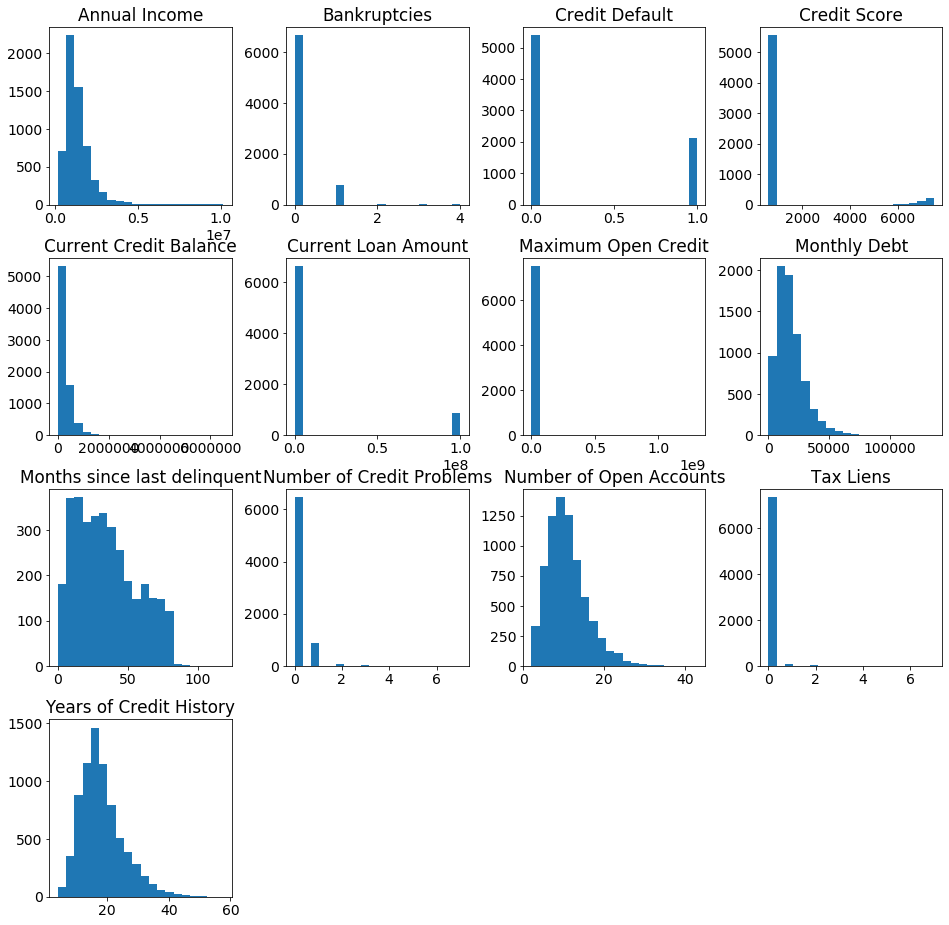

In [20]:
train_df_num_features.hist(figsize=(16,16), bins=20, grid=False);

**Обзор номинативных признаков**

In [21]:
cat_colnames = train_df.select_dtypes(include='object').columns.tolist()
cat_colnames

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [22]:
for cat_colname in train_df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
nan           371
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses 

### Обработка выбросов

**Annual Income**

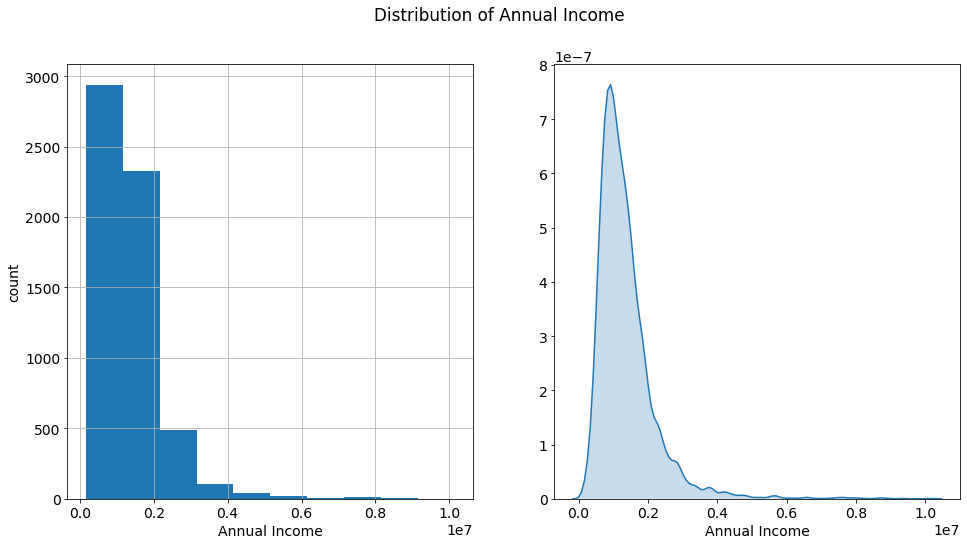

In [23]:
# При рассмотрении признака Annual Income, пришла к выводу, что присутствуют выбросы.
plt.figure(figsize = (16, 8))

plt.subplot(121)
train_df['Annual Income'].hist()
plt.ylabel('count')
plt.xlabel('Annual Income')

plt.subplot(122)
sns.kdeplot(train_df['Annual Income'], shade=True, legend=False)
plt.xlabel('Annual Income')

plt.suptitle('Distribution of Annual Income')
plt.show()

In [24]:
# Находим выбросы в признаке Annual Income.
annual_income_mean = train_df['Annual Income'].mean()
annual_income_std = train_df['Annual Income'].std()
annual_income_cut_off = annual_income_std * 3 
annual_income_lower = annual_income_mean - annual_income_cut_off
annual_income_upper = annual_income_mean + annual_income_cut_off
annual_income_outliers = [x for x in train_df['Annual Income'] if x < annual_income_lower or x > annual_income_upper]
annual_income_outliers_removed = [x for x in train_df['Annual Income'] if x > annual_income_lower and x < annual_income_upper]


annual_income_mean = test_df['Annual Income'].mean()
annual_income_std = test_df['Annual Income'].std()
annual_income_cut_off = annual_income_std * 3 
annual_income_lower = annual_income_mean - annual_income_cut_off
annual_income_upper = annual_income_mean + annual_income_cut_off
annual_income_outliers = [x for x in test_df['Annual Income'] if x < annual_income_lower or x > annual_income_upper]
annual_income_outliers_removed = [x for x in test_df['Annual Income'] if x > annual_income_lower and x < annual_income_upper]


In [25]:
# Заменим выбросы на медиану.
train_df.loc[train_df['Annual Income'] > annual_income_upper, 'Annual Income'] = train_df['Annual Income'].median()

test_df.loc[test_df['Annual Income'] > annual_income_upper, 'Annual Income'] = test_df['Annual Income'].median()

**Number of Open Accounts**

In [26]:
# Рассмотрим Number of Open Accounts на наличие выбросов.
train_df['Number of Open Accounts'].value_counts()

9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14
27.0     14
26.0     12
30.0     11
29.0     10
32.0      6
33.0      6
31.0      6
34.0      2
37.0      2
43.0      1
35.0      1
41.0      1
38.0      1
42.0      1
Name: Number of Open Accounts, dtype: int64

In [27]:
# Находим выбросы в признаке Number of Open Accounts.
number_of_acc_mean = train_df['Number of Open Accounts'].mean()
number_of_acc_std = train_df['Number of Open Accounts'].std()
number_of_acc_cut_off = number_of_acc_std * 3 
number_of_acc_lower = number_of_acc_mean - number_of_acc_cut_off
number_of_acc_upper = number_of_acc_mean + number_of_acc_cut_off
number_of_acc_outliers = [x for x in train_df['Number of Open Accounts'] if x < number_of_acc_lower or x > number_of_acc_upper]
number_of_acc_outliers_removed = [x for x in train_df['Number of Open Accounts'] if x > number_of_acc_lower and x < number_of_acc_upper]


number_of_acc_mean = test_df['Number of Open Accounts'].mean()
number_of_acc_std = test_df['Number of Open Accounts'].std()
number_of_acc_cut_off = number_of_acc_std * 3 
number_of_acc_lower = number_of_acc_mean - number_of_acc_cut_off
number_of_acc_upper = number_of_acc_mean + number_of_acc_cut_off
number_of_acc_outliers = [x for x in test_df['Number of Open Accounts'] if x < number_of_acc_lower or x > number_of_acc_upper]
number_of_acc_outliers_removed = [x for x in test_df['Number of Open Accounts'] if x > number_of_acc_lower and x < number_of_acc_upper]

In [28]:
# Выбросами будет считать все значения выше 25. 
number_of_acc_upper 

25.742722281741933

In [29]:
# Заменим выбросы выше 25 на медиану.
train_df.loc[train_df['Number of Open Accounts'] > 25, 'Number of Open Accounts'] = train_df['Number of Open Accounts'].median()

test_df.loc[train_df['Number of Open Accounts'] > 25, 'Number of Open Accounts'] =  test_df['Number of Open Accounts'].median()

### Обработка пропусков

In [30]:
train_df.isnull().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [31]:
# Признак Months since last delinquent решено удалить, т.к. пропущено больше половины значений.
train_df.drop("Months since last delinquent", axis=1, inplace=True)

test_df.drop("Months since last delinquent", axis=1, inplace=True)

In [32]:
# Заполним пропуски Annual Income средним значением.
train_df.loc[train_df['Annual Income'].isnull(), 'Annual Income'] = train_df['Annual Income'].mean()

test_df.loc[test_df['Annual Income'].isnull(), 'Annual Income'] = test_df['Annual Income'].mean()

In [33]:
# Заполним пропуски Credit Score средним значением.
train_df.loc[train_df['Credit Score'].isnull(), 'Credit Score'] = train_df['Credit Score'].mean()

test_df.loc[test_df['Credit Score'].isnull(), 'Credit Score'] = test_df['Credit Score'].mean()

In [34]:
# Заполним пропуски Bankruptcies также средним значением.
train_df.loc[train_df['Bankruptcies'].isnull(), 'Bankruptcies'] = train_df['Bankruptcies'].mean()

test_df.loc[test_df['Bankruptcies'].isnull(), 'Bankruptcies'] = test_df['Bankruptcies'].mean()

### Построение новых признаков

**Dummies**

In [35]:
train_df['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [36]:
#приобразуем признак Home Ownnership в бинарный вид
train_df = pd.concat([train_df, pd.get_dummies(train_df['Home Ownership'])], axis=1)

test_df = pd.concat([test_df, pd.get_dummies(test_df['Home Ownership'])], axis=1)

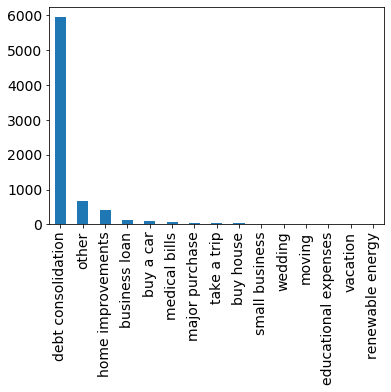

In [37]:
train_df['Purpose'].value_counts().plot.bar()

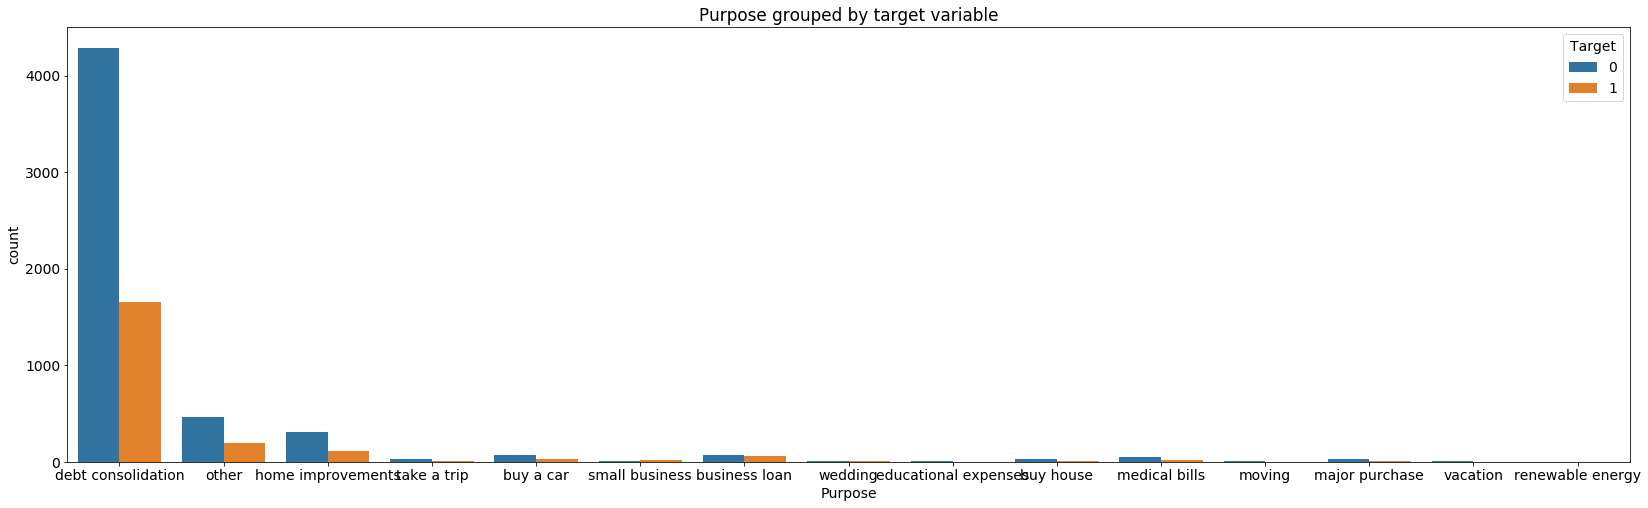

In [38]:
# рассмотрим распределение целевой переменной в зависимости от цели кредита.
TARGET_NAME = 'Credit Default'

plt.figure(figsize=(28, 8))

sns.countplot(x="Purpose", hue=TARGET_NAME, data=train_df)
plt.title('Purpose grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [39]:
# Сравним Purpose в выборке test и train.
test_df['Purpose'].value_counts()

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
educational expenses       3
vacation                   3
wedding                    2
moving                     1
Name: Purpose, dtype: int64

In [40]:
train_df['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [41]:
# приобразуем признак Purpose в бинарный вид
train_df = pd.concat([train_df, pd.get_dummies(train_df['Purpose'])], axis=1)

test_df = pd.concat([test_df, pd.get_dummies(test_df['Purpose'])], axis=1)

In [42]:
# Т.к. в тестовой выборке отсутсвует вариант 'renewable energy', а в тренировочной выборке таких вариантов всего 2, удалим этот признак.
train_df.drop("renewable energy", axis=1, inplace=True)

In [43]:
# Объеденю несколько признаков (wedding, buy house, buy a car, take a trip, moving ) в один столбец summery_purpose.
#    if row['wedding'] == 1 or row['buy house'] == 1 or row['buy a car'] == 1 or row['take a trip'] == 1 or row['moving'] == 1 or row['educational expenses'] == 1 :
#        return 1
#    else:
#        return 0

#train_df['summery_purpose'] = train_df.apply(select, axis=1)


#test_df['summery_purpose'] = test_df.apply(select, axis=1)

In [44]:
# Рассмотрим признак Years in current job.
train_df['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
nan           371
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [45]:
# Признак Years in current job изменим на тип int, а пропуски nan заменим на 10, т.к. это самое популярное значение.
years_dict = {
    "Years in current job": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        "nan": 10
    }
}
train_df = train_df.replace(years_dict)
train_df['Years in current job'] = train_df['Years in current job'].astype('int64')


In [46]:
train_df['Years in current job'].value_counts()

10    2703
2      705
3      620
0      563
5      516
1      504
4      469
6      426
7      396
8      339
9      259
Name: Years in current job, dtype: int64

In [47]:
train_df.isnull().sum()

Home Ownership               0
Annual Income                0
Years in current job         0
Tax Liens                    0
Number of Open Accounts      0
Years of Credit History      0
Maximum Open Credit          0
Number of Credit Problems    0
Bankruptcies                 0
Purpose                      0
Term                         0
Current Loan Amount          0
Current Credit Balance       0
Monthly Debt                 0
Credit Score                 0
Credit Default               0
Have Mortgage                0
Home Mortgage                0
Own Home                     0
Rent                         0
business loan                0
buy a car                    0
buy house                    0
debt consolidation           0
educational expenses         0
home improvements            0
major purchase               0
medical bills                0
moving                       0
other                        0
small business               0
take a trip                  0
vacation

In [48]:
test_df = test_df.replace(years_dict)
test_df['Years in current job'] = test_df['Years in current job'].astype('int64')

In [49]:
test_df.isnull().sum()

Home Ownership               0
Annual Income                0
Years in current job         0
Tax Liens                    0
Number of Open Accounts      0
Years of Credit History      0
Maximum Open Credit          0
Number of Credit Problems    0
Bankruptcies                 0
Purpose                      0
Term                         0
Current Loan Amount          0
Current Credit Balance       0
Monthly Debt                 0
Credit Score                 0
Have Mortgage                0
Home Mortgage                0
Own Home                     0
Rent                         0
business loan                0
buy a car                    0
buy house                    0
debt consolidation           0
educational expenses         0
home improvements            0
major purchase               0
medical bills                0
moving                       0
other                        0
small business               0
take a trip                  0
vacation                     0
wedding 

In [50]:
# Заменим признак Term на бинарные значения.
train_df['Term_bin'] = train_df['Term'].replace({'Short Term':0, 'Long Term':1})

test_df['Term_bin'] = test_df['Term'].replace({'Short Term':0, 'Long Term':1})

In [51]:
# Создадим новый признак PTI (Pay-To-Income) - отношение суммы ежемесячных платежей по кредиту заемщика к совокупному доходу за тот же период.
train_df['PTI'] = train_df['Monthly Debt'] *12 /train_df['Annual Income']

test_df['PTI'] = test_df['Monthly Debt'] *12 /test_df['Annual Income']

#  Создадим новый признак PBP (PayBack Period)- сколько лет понадобится на выплаты кредита только из дохода
train_df['PBP'] = (train_df['Current Loan Amount'] + train_df['Current Credit Balance'])*12 /train_df['Annual Income']

test_df['PBP'] = (test_df['Current Loan Amount'] + test_df['Current Credit Balance'])*12 /test_df['Annual Income']

In [52]:
train_df.dtypes.value_counts()

uint8      18
float64    13
int64       3
object      3
dtype: int64

In [53]:
test_df.dtypes.value_counts()

uint8      18
float64    13
object      3
int64       2
dtype: int64

In [54]:
train_df.dtypes

Home Ownership                object
Annual Income                float64
Years in current job           int64
Tax Liens                    float64
Number of Open Accounts      float64
Years of Credit History      float64
Maximum Open Credit          float64
Number of Credit Problems    float64
Bankruptcies                 float64
Purpose                       object
Term                          object
Current Loan Amount          float64
Current Credit Balance       float64
Monthly Debt                 float64
Credit Score                 float64
Credit Default                 int64
Have Mortgage                  uint8
Home Mortgage                  uint8
Own Home                       uint8
Rent                           uint8
business loan                  uint8
buy a car                      uint8
buy house                      uint8
debt consolidation             uint8
educational expenses           uint8
home improvements              uint8
major purchase                 uint8
m

**Выделение целевой переменной и групп признаков**

**Анализ целевой переменной**

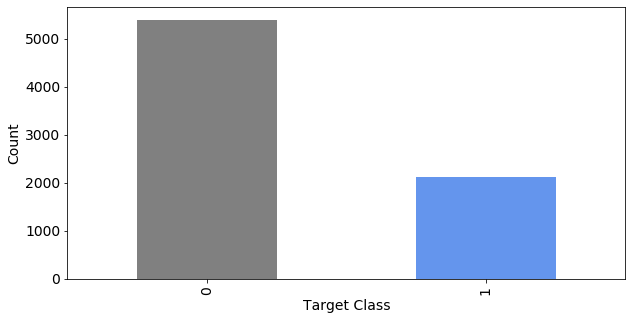

In [55]:
# Рассмторим распределение целевой переменной. Вывод: данные несбалансированы.
train_df['Credit Default'].value_counts()
train_df['Credit Default'].value_counts().plot(kind='bar', figsize=(10,5), color = ['grey', 'cornflowerblue'])
plt.xlabel('Target Class')
plt.ylabel('Count') 
plt.show()

**Корреляция с базовыми признаками**

In [56]:
train_df.columns.tolist()

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default',
 'Have Mortgage',
 'Home Mortgage',
 'Own Home',
 'Rent',
 'business loan',
 'buy a car',
 'buy house',
 'debt consolidation',
 'educational expenses',
 'home improvements',
 'major purchase',
 'medical bills',
 'moving',
 'other',
 'small business',
 'take a trip',
 'vacation',
 'wedding',
 'Term_bin',
 'PTI',
 'PBP']

In [57]:
TARGET_NAME = 'Credit Default'

NUM_FEATURE_NAMES = [ 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'PTI',
 'PBP']
    
CAT_FEATURE_NAMES = [ 'Have Mortgage',
 'Home Mortgage',
 'Own Home',
 'Rent',
 'business loan',
 'debt consolidation',
 'home improvements',
 'major purchase',
 'medical bills',
 'other',
 'small business',
 'wedding',
 'take a trip',
 'vacation',
 'buy house',
 'buy a car',
 'moving',
 'educational expenses',
 'Term_bin']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES
    




In [58]:
SELECTED_FEATURE_NAMES

['Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'PTI',
 'PBP',
 'Have Mortgage',
 'Home Mortgage',
 'Own Home',
 'Rent',
 'business loan',
 'debt consolidation',
 'home improvements',
 'major purchase',
 'medical bills',
 'other',
 'small business',
 'wedding',
 'take a trip',
 'vacation',
 'buy house',
 'buy a car',
 'moving',
 'educational expenses',
 'Term_bin']

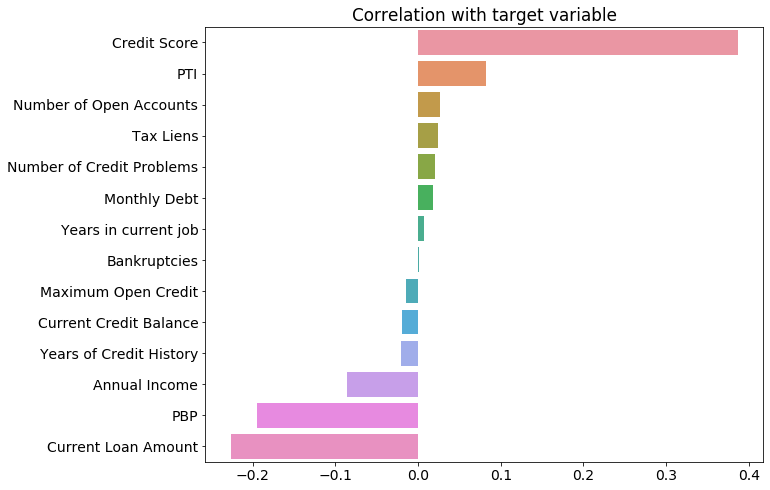

In [59]:
corr_with_target = train_df[NUM_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

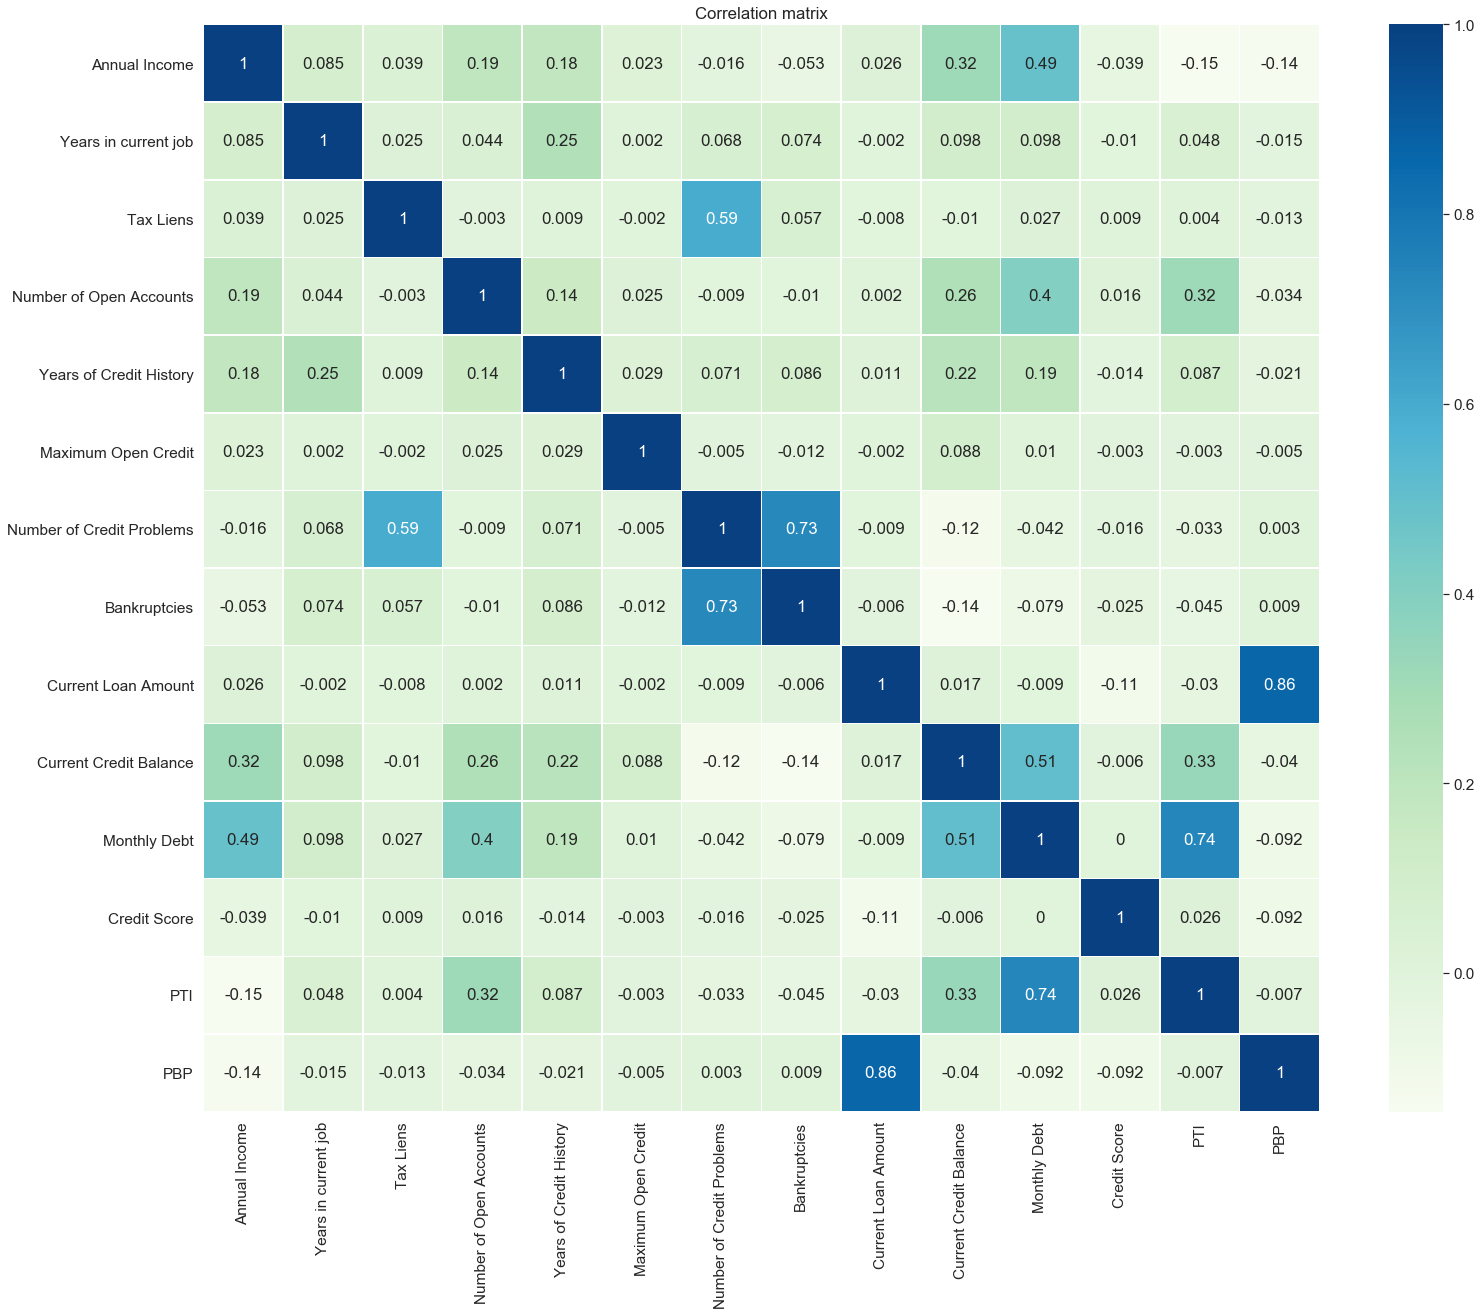

In [60]:
# Матрица корреляций
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(train_df[NUM_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### Нормализация данных

In [61]:
scaler = StandardScaler()
train_stand_features = scaler.fit_transform(train_df[NUM_FEATURE_NAMES])


In [62]:
train_stand_features= pd.DataFrame(train_stand_features, columns=NUM_FEATURE_NAMES)
other_features = train_df[CAT_FEATURE_NAMES]

In [63]:
train_stand_features.reset_index(inplace=True)
train_stand_features

,index,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,PTI,PBP
0,0,-1.428789e+00,1.075647,-0.110953,0.022664,1.133645,-0.016174,1.664779,2.545372,2.760520,-0.762772,-0.872085,-0.281552,0.228692,5.605518
1,1,-4.806798e-01,1.075647,-0.110953,0.920821,-0.428528,0.014763,-0.340979,-0.337765,-0.363620,0.330781,0.004909,-0.289955,0.416764,-0.308228
2,2,-9.588784e-01,0.526268,-0.110953,0.022664,2.369181,0.014807,-0.340979,-0.337765,2.760520,0.058379,-0.391034,-0.286453,0.448200,3.489218
3,3,-8.652609e-01,-0.023111,-0.110953,-0.650955,0.593985,-0.049781,1.664779,2.545372,-0.368118,-0.610282,-0.584980,-0.320064,-0.063755,-0.318910
4,4,-9.155173e-01,0.526268,-0.110953,0.471742,-0.669954,-0.034902,1.664779,-0.337765,-0.367978,-0.618292,-0.933631,-0.302559,-0.669732,-0.318554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,7495,-1.568188e+00,-1.671247,-0.110953,-1.773652,-1.394234,-0.052248,-0.340979,-0.337765,-0.367868,-0.680639,-1.376362,-0.317964,-1.237030,-0.312207
7496,7496,4.065320e-01,-1.396558,-0.110953,-0.201876,1.162048,-0.016152,-0.340979,-0.337765,-0.358011,0.524039,-0.463816,4.382648,-0.784591,-0.309845
7497,7497,1.008350e+00,-0.023111,-0.110953,0.247203,1.957336,0.052029,-0.340979,-0.337765,2.760520,0.591407,-0.489306,-0.282252,-0.996650,1.201982
7498,7498,-4.062366e-16,1.075647,-0.110953,2.268057,1.162048,0.012237,-0.340979,-0.337765,-0.352647,0.585907,1.576689,0.000000,1.747389,-0.302645


In [64]:
other_features.reset_index(inplace=True)
other_features

,index,Have Mortgage,Home Mortgage,Own Home,Rent,business loan,debt consolidation,home improvements,major purchase,medical bills,other,small business,wedding,take a trip,vacation,buy house,buy a car,moving,educational expenses,Term_bin
0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,7495,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
7496,7496,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
7497,7497,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7498,7498,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [65]:
train_df_stand=pd.merge(train_stand_features, other_features, on='index', how='inner')

In [66]:
train_df_stand.head()

,index,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,...,other,small business,wedding,take a trip,vacation,buy house,buy a car,moving,educational expenses,Term_bin
0,0,-1.428789,1.075647,-0.110953,0.022664,1.133645,-0.016174,1.664779,2.545372,2.760520,...,0,0,0,0,0,0,0,0,0,0
1,1,-0.480680,1.075647,-0.110953,0.920821,-0.428528,0.014763,-0.340979,-0.337765,-0.363620,...,0,0,0,0,0,0,0,0,0,1
2,2,-0.958878,0.526268,-0.110953,0.022664,2.369181,0.014807,-0.340979,-0.337765,2.760520,...,0,0,0,0,0,0,0,0,0,0
3,3,-0.865261,-0.023111,-0.110953,-0.650955,0.593985,-0.049781,1.664779,2.545372,-0.368118,...,0,0,0,0,0,0,0,0,0,0
4,4,-0.915517,0.526268,-0.110953,0.471742,-0.669954,-0.034902,1.664779,-0.337765,-0.367978,...,0,0,0,0,0,0,0,0,0,0


In [67]:
train_df_stand.drop("index", axis=1, inplace=True)
train_df_stand.head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,...,other,small business,wedding,take a trip,vacation,buy house,buy a car,moving,educational expenses,Term_bin
0,-1.428789,1.075647,-0.110953,0.022664,1.133645,-0.016174,1.664779,2.545372,2.760520,-0.762772,...,0,0,0,0,0,0,0,0,0,0
1,-0.480680,1.075647,-0.110953,0.920821,-0.428528,0.014763,-0.340979,-0.337765,-0.363620,0.330781,...,0,0,0,0,0,0,0,0,0,1
2,-0.958878,0.526268,-0.110953,0.022664,2.369181,0.014807,-0.340979,-0.337765,2.760520,0.058379,...,0,0,0,0,0,0,0,0,0,0
3,-0.865261,-0.023111,-0.110953,-0.650955,0.593985,-0.049781,1.664779,2.545372,-0.368118,-0.610282,...,0,0,0,0,0,0,0,0,0,0
4,-0.915517,0.526268,-0.110953,0.471742,-0.669954,-0.034902,1.664779,-0.337765,-0.367978,-0.618292,...,0,0,0,0,0,0,0,0,0,0


**Нормализация валидационных данных**

In [68]:
valid_stand_features = scaler.fit_transform(train_df[NUM_FEATURE_NAMES])

In [69]:
valid_stand_features = pd.DataFrame(valid_stand_features, columns=NUM_FEATURE_NAMES)
other_features = train_df[CAT_FEATURE_NAMES]

In [70]:
valid_stand_features.reset_index(inplace=True)
valid_stand_features

,index,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,PTI,PBP
0,0,-1.428789e+00,1.075647,-0.110953,0.022664,1.133645,-0.016174,1.664779,2.545372,2.760520,-0.762772,-0.872085,-0.281552,0.228692,5.605518
1,1,-4.806798e-01,1.075647,-0.110953,0.920821,-0.428528,0.014763,-0.340979,-0.337765,-0.363620,0.330781,0.004909,-0.289955,0.416764,-0.308228
2,2,-9.588784e-01,0.526268,-0.110953,0.022664,2.369181,0.014807,-0.340979,-0.337765,2.760520,0.058379,-0.391034,-0.286453,0.448200,3.489218
3,3,-8.652609e-01,-0.023111,-0.110953,-0.650955,0.593985,-0.049781,1.664779,2.545372,-0.368118,-0.610282,-0.584980,-0.320064,-0.063755,-0.318910
4,4,-9.155173e-01,0.526268,-0.110953,0.471742,-0.669954,-0.034902,1.664779,-0.337765,-0.367978,-0.618292,-0.933631,-0.302559,-0.669732,-0.318554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,7495,-1.568188e+00,-1.671247,-0.110953,-1.773652,-1.394234,-0.052248,-0.340979,-0.337765,-0.367868,-0.680639,-1.376362,-0.317964,-1.237030,-0.312207
7496,7496,4.065320e-01,-1.396558,-0.110953,-0.201876,1.162048,-0.016152,-0.340979,-0.337765,-0.358011,0.524039,-0.463816,4.382648,-0.784591,-0.309845
7497,7497,1.008350e+00,-0.023111,-0.110953,0.247203,1.957336,0.052029,-0.340979,-0.337765,2.760520,0.591407,-0.489306,-0.282252,-0.996650,1.201982
7498,7498,-4.062366e-16,1.075647,-0.110953,2.268057,1.162048,0.012237,-0.340979,-0.337765,-0.352647,0.585907,1.576689,0.000000,1.747389,-0.302645


In [71]:
other_features.reset_index(inplace=True)
other_features

,index,Have Mortgage,Home Mortgage,Own Home,Rent,business loan,debt consolidation,home improvements,major purchase,medical bills,other,small business,wedding,take a trip,vacation,buy house,buy a car,moving,educational expenses,Term_bin
0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,7495,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
7496,7496,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
7497,7497,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7498,7498,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [72]:
valid_df_stand=pd.merge(valid_stand_features, other_features, on='index', how='inner')

In [73]:
valid_df_stand.drop("index", axis=1, inplace=True)
valid_df_stand.head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,...,other,small business,wedding,take a trip,vacation,buy house,buy a car,moving,educational expenses,Term_bin
0,-1.428789,1.075647,-0.110953,0.022664,1.133645,-0.016174,1.664779,2.545372,2.760520,-0.762772,...,0,0,0,0,0,0,0,0,0,0
1,-0.480680,1.075647,-0.110953,0.920821,-0.428528,0.014763,-0.340979,-0.337765,-0.363620,0.330781,...,0,0,0,0,0,0,0,0,0,1
2,-0.958878,0.526268,-0.110953,0.022664,2.369181,0.014807,-0.340979,-0.337765,2.760520,0.058379,...,0,0,0,0,0,0,0,0,0,0
3,-0.865261,-0.023111,-0.110953,-0.650955,0.593985,-0.049781,1.664779,2.545372,-0.368118,-0.610282,...,0,0,0,0,0,0,0,0,0,0
4,-0.915517,0.526268,-0.110953,0.471742,-0.669954,-0.034902,1.664779,-0.337765,-0.367978,-0.618292,...,0,0,0,0,0,0,0,0,0,0


**Стандартизация тестовых данных**

In [74]:
test_stand_features = scaler.transform(test_df[NUM_FEATURE_NAMES])

In [75]:
test_stand_features = pd.DataFrame(test_stand_features, columns=NUM_FEATURE_NAMES)
other_features = test_df[CAT_FEATURE_NAMES]

In [76]:
test_stand_features.reset_index(inplace=True)
test_stand_features

,index,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,PTI,PBP
0,0,-0.001072,-0.572489,-0.110953,-0.426415,-0.826171,-0.045191,-0.340979,-0.337765,-0.366831,-0.578660,-0.964404,0.058419,-1.172448,-0.320724
1,1,-1.865417,-1.396558,-0.110953,-1.100033,2.042545,-0.055488,-0.340979,-0.337765,-0.369468,-0.767016,-1.341313,-0.316563,-0.575845,-0.311294
2,2,-0.259001,-0.847179,-0.110953,-0.201876,-0.655753,-0.046212,-0.340979,-0.337765,-0.365650,-0.450977,0.034760,4.277614,0.207891,-0.318026
3,3,-0.140753,1.075647,-0.110953,1.145360,-0.187101,-0.030505,-0.340979,-0.337765,-0.365111,-0.241102,0.775161,-0.288554,1.001847,-0.316538
4,4,1.814508,-0.023111,-0.110953,0.022664,0.750203,0.016357,-0.340979,-0.337765,-0.347561,0.426483,2.036777,-0.311661,0.452303,-0.311934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,2495,-0.490161,1.075647,-0.110953,0.696282,1.531289,-0.024087,1.664779,2.545372,2.760520,-0.399868,-0.274062,-0.284353,0.019852,2.480197
2496,2496,-0.001072,-1.121868,-0.110953,0.920821,-0.187101,0.049461,-0.340979,-0.337765,-0.357244,3.616282,1.231057,0.058419,1.351701,-0.284687
2497,2497,-0.225386,-1.121868,-0.110953,8.330621,-0.783567,0.047505,-0.340979,-0.337765,-0.358435,1.216311,1.559416,-0.319364,2.119634,-0.299622
2498,2498,-1.007544,1.075647,-0.110953,0.696282,1.488684,0.000039,-0.340979,-0.337765,-0.363846,0.319065,-0.403192,-0.285053,0.510873,-0.300982


In [77]:
other_features.reset_index(inplace=True)
other_features

,index,Have Mortgage,Home Mortgage,Own Home,Rent,business loan,debt consolidation,home improvements,major purchase,medical bills,other,small business,wedding,take a trip,vacation,buy house,buy a car,moving,educational expenses,Term_bin
0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,2495,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2496,2496,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2497,2497,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2498,2498,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [78]:
test_df_stand=pd.merge(test_stand_features, other_features, on='index', how='inner')

In [79]:
test_df_stand.drop("index", axis=1, inplace=True)
test_df_stand.head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,...,other,small business,wedding,take a trip,vacation,buy house,buy a car,moving,educational expenses,Term_bin
0,-0.001072,-0.572489,-0.110953,-0.426415,-0.826171,-0.045191,-0.340979,-0.337765,-0.366831,-0.578660,...,0,0,0,0,0,0,0,0,0,0
1,-1.865417,-1.396558,-0.110953,-1.100033,2.042545,-0.055488,-0.340979,-0.337765,-0.369468,-0.767016,...,0,0,0,0,0,0,0,0,1,0
2,-0.259001,-0.847179,-0.110953,-0.201876,-0.655753,-0.046212,-0.340979,-0.337765,-0.365650,-0.450977,...,0,0,0,0,0,0,0,0,0,0
3,-0.140753,1.075647,-0.110953,1.145360,-0.187101,-0.030505,-0.340979,-0.337765,-0.365111,-0.241102,...,0,0,0,0,0,0,0,0,0,0
4,1.814508,-0.023111,-0.110953,0.022664,0.750203,0.016357,-0.340979,-0.337765,-0.347561,0.426483,...,0,0,0,0,0,0,0,0,0,1


### Разбиение на train и test

In [80]:
X = train_df_stand[SELECTED_FEATURE_NAMES]
y = train_df[TARGET_NAME]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [81]:
X_test = test_df_stand[SELECTED_FEATURE_NAMES]
X_test.head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,...,other,small business,wedding,take a trip,vacation,buy house,buy a car,moving,educational expenses,Term_bin
0,-0.001072,-0.572489,-0.110953,-0.426415,-0.826171,-0.045191,-0.340979,-0.337765,-0.366831,-0.578660,...,0,0,0,0,0,0,0,0,0,0
1,-1.865417,-1.396558,-0.110953,-1.100033,2.042545,-0.055488,-0.340979,-0.337765,-0.369468,-0.767016,...,0,0,0,0,0,0,0,0,1,0
2,-0.259001,-0.847179,-0.110953,-0.201876,-0.655753,-0.046212,-0.340979,-0.337765,-0.365650,-0.450977,...,0,0,0,0,0,0,0,0,0,0
3,-0.140753,1.075647,-0.110953,1.145360,-0.187101,-0.030505,-0.340979,-0.337765,-0.365111,-0.241102,...,0,0,0,0,0,0,0,0,0,0
4,1.814508,-0.023111,-0.110953,0.022664,0.750203,0.016357,-0.340979,-0.337765,-0.347561,0.426483,...,0,0,0,0,0,0,0,0,0,1


### Балансировка целевой переменной

In [82]:
#балансировка тренировочных данных
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]    
df_balanced[TARGET_NAME].value_counts()

0    3795
1    2910
Name: Credit Default, dtype: int64

In [83]:
# На тренировочных данных модель, построенная на логистической регрессии показала лучшие параметры.
# Мною были испробованы модели Сatboost, k ближайших соседей, градиентный бустинг. Применяла подбор гиперпараметров.


**Логистическая регрессия**

In [84]:
model_lr = LogisticRegression(random_state=1)
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_valid_pred = model_lr.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.69      0.85      0.76      3795
           1       0.72      0.51      0.59      2910

    accuracy                           0.70      6705
   macro avg       0.70      0.68      0.68      6705
weighted avg       0.70      0.70      0.69      6705

TEST

              precision    recall  f1-score   support

           0       0.80      0.83      0.82      1592
           1       0.55      0.50      0.52       658

    accuracy                           0.73      2250
   macro avg       0.68      0.67      0.67      2250
weighted avg       0.73      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1322  270
1                328  330


In [85]:
y_test_pred = model_lr.predict(X_test)


In [86]:
test_df.reset_index(inplace=True)
pd.DataFrame({ 'Id': test_df['index'], 'Credit Default': y_test_pred }).to_csv(PREPARED_DATASET_PATH, index=False)

In [88]:
result = pd.read_csv(PREPARED_DATASET_PATH)
result.tail()

,Id,Credit Default
2495,2495,0
2496,2496,0
2497,2497,0
2498,2498,0
2499,2499,1
